What structure do protoclusters possess, and where do they sit in the overall LSS?

- Plot distribution of galaxy coordinates for a given protocluster
- Plot nearest N critical points (maxima)


In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import distance

from itertools import product

Read data and set some variables we need later

In [9]:
gals = pd.read_csv('data/henriques2015a_z2p07_sfr.csv', 
                   skiprows=111, skipfooter=1, engine='python')

In [10]:
cluster_masses = np.log10(gals[gals['z0_central_mcrit200'] > 1e4].groupby(['z0_centralId'], sort=False)['z0_central_mcrit200'].mean() * 1e10)

Start

In [2]:
segs = pd.read_csv('data/disperse/coods_2p07_sfr.ascii.NDnet_s7.up.NDskl.S010.BRK.a.segs', skiprows=3, header=None, delim_whitespace=True)
segs.columns = ['U0','U1','U2','V0','V1','V2','value_U','value_V','type','boundary']

IOError: File data/disperse/coods_2p07_sfr.ascii.NDnet_s7.up.NDskl.S010.BRK.a.segs does not exist

In [401]:
crits = pd.read_csv('data/disperse/coods_2p07_sfr.ascii.NDnet_s7.up.NDskl.S010.BRK.a.crits', skiprows=3, header=None, delim_whitespace=True)
crits.columns = ['X0','X1','X2','value','type','pair_id','boundary']

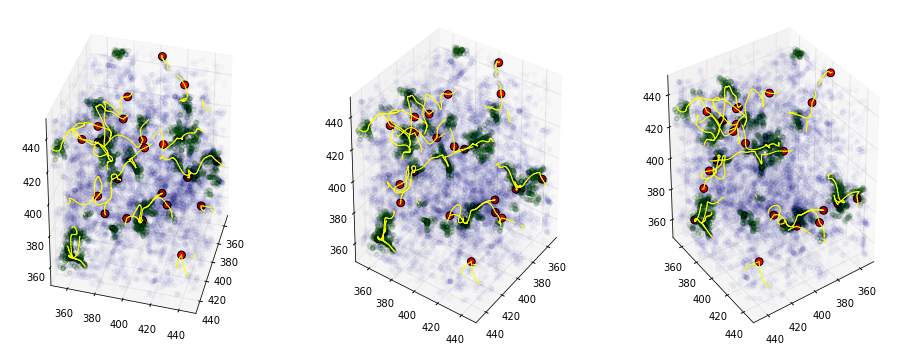

In [412]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')


lolim = 350
hilim = 450

for ax, angle in zip([ax1, ax2, ax3], [15,35,55]):

    ax.set_xlim(lolim, hilim)
    ax.set_ylim(lolim, hilim)
    ax.set_zlim(lolim, hilim)

    mask = (gals['zn_x'] < hilim) & (gals['zn_y'] < hilim) & (gals['zn_z'] < hilim) \
            & (gals['zn_x'] > lolim) & (gals['zn_y'] > lolim) & (gals['zn_z'] > lolim) 

    ax.scatter(gals.loc[(gals['z0_central_mcrit200'] < 1e4) & mask]['zn_x'], 
               gals.loc[(gals['z0_central_mcrit200'] < 1e4) & mask]['zn_y'],
               gals.loc[(gals['z0_central_mcrit200'] < 1e4) & mask]['zn_z'], 
               alpha=0.01, c='blue')   
    
    ax.scatter(gals.loc[(gals['z0_central_mcrit200'] > 1e4) & mask]['zn_x'],
              gals.loc[(gals['z0_central_mcrit200'] > 1e4) & mask]['zn_y'],
              gals.loc[(gals['z0_central_mcrit200'] > 1e4) & mask]['zn_z'],
              alpha=0.1, cmap='Set2',
              c='green') #gals.loc[(gals['z0_central_mcrit200'] > 1e4) & mask]['z0_centralId'])

    mask = (crits['X0'] < hilim) & (crits['X1'] < hilim) & (crits['X2'] < hilim) \
            & (crits['X0'] > lolim) & (crits['X1'] > lolim) & (crits['X2'] > lolim)

    ax.scatter(crits[(crits['type'] == 2) & mask]['X0'],
               crits[(crits['type'] == 2) & mask]['X1'],
               zs=crits[(crits['type'] == 2) & mask]['X2'],
               c='red', alpha=1, s=60)


    mask = (segs['U0'] < hilim) & (segs['U1'] < hilim) & (segs['U2'] < hilim) \
            & (segs['U0'] > lolim) & (segs['U1'] > lolim) & (segs['U2'] > lolim)

    for i, row in segs.loc[mask].iterrows():
        ax.plot(row[['U0','V0']], row[['U1','V1']], row[['U2','V2']], c='yellow')

    ax.view_init(30, angle)


Find filamentary structure (calculated over the whole box) in the vicinity of protocluster regions.

Use a KDtree to find nearby filaments. Build on coordinates of both ends of filaments.

In [1]:
from periodic_kdtree import PeriodicCKDTree

In [ ]:
TU = PeriodicCKDTree(dimensions, segs[['U0','U1','U2']])
TV = PeriodicCKDTree(dimensions, segs[['V0','V1','V2']])

In [ ]:
cluster_ids = pd.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId'])

print "Clusters: ", len(cluster_ids)

cluster_stats = [None] * len(cluster_ids)

dimensions = np.array([L, L, L])

print "Building periodic KDtree..."
T = PeriodicCKDTree(dimensions, gals[['zn_x','zn_y','zn_z']])

for i, cluster in enumerate(cluster_ids):

    # print i
    # sys.stdout.flush()

    coods = gals[gals['z0_centralId']==cluster][['zn_x','zn_y','zn_z']].copy()
    coods = coods.reset_index()

    if np.abs(coods['zn_x'].max() - coods['zn_x'].min()) > L/2:
        coods['zn_x'] = coods['zn_x'] - L
        coods.loc[coods['zn_x'] < -L/2, 'zn_x'] = gals[gals['z0_centralId'] == cluster]['zn_x'][coods['zn_x'] < -L/2]

    if np.abs(coods['zn_y'].max() - coods['zn_y'].min()) > L/2:
        coods['zn_y'] = coods['zn_y'] - L
        coods.loc[coods['zn_y'] < -L/2, 'zn_y'] = gals[gals['z0_centralId'] == cluster]['zn_y'][coods['zn_y'] < -L/2]

    if np.abs(coods['zn_z'].max() - coods['zn_z'].min()) > L/2:
        coods['zn_z'] = coods['zn_z'] - L
        coods.loc[coods['zn_z'] < -L/2, 'zn_z'] = gals[gals['z0_centralId'] == cluster]['zn_z'][coods['zn_z'] < -L/2]

    center = np.mean(coods)
    
    U_index = TU.query_ball_point(center, r=R)
    V_index = TV.query_ball_point(center, r=R)
    
    segs[U_index & V_index]
    
    

Want to plot all the structure in the region of a given protolcluster.

Define region using:
- a bounding sphere
- or (ideally) a bounding ellipse

In [506]:
idx = 300
index = np.int(pd.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId'])[idx])
print "Index:",index

coods = gals.loc[(gals['z0_central_mcrit200'] > 1e4) & (gals['z0_centralId'] == index)][['zn_x','zn_y','zn_z']]
print "N(gals):", coods.shape[0]

distances = squareform(distance.pdist(coods))
print "Max distance:", distances.max()

max_coods = coods.iloc[np.where(distances == distances.max())[0]]

centre = max_coods.iloc[0] - (max_coods.iloc[0] - max_coods.iloc[1]) / 2

Index: 72000020000005
N(gals): 61
Max distance: 10.8831305167


In [508]:
crits_insphere = crits[crits[['X0','X1','X2']].apply(lambda row: distance.euclidean(centre, row), axis=1) < distances.max() / 2]
crits_insphere

,X0,X1,X2,value,type,pair_id,boundary
149,54.9252,410.485,22.3353,6603.540000,3,2883,0
3384,54.6093,409.990,24.3844,0.215678,4,-1,0


In [509]:
segs_insphere_A = segs[segs[['U0','U1','U2']].apply(lambda row: distance.euclidean(centre, row), axis=1) < distances.max() / 2]
segs_insphere_B = segs[segs[['V0','V1','V2']].apply(lambda row: distance.euclidean(centre, row), axis=1) < distances.max() / 2]
segs_insphere = pd.concat([segs_insphere_A, segs_insphere_B])
segs_insphere = segs_insphere.drop_duplicates()

print segs_insphere.shape

(12, 10)


Number of critical points:  2
Total length of filament:  11.6227960776


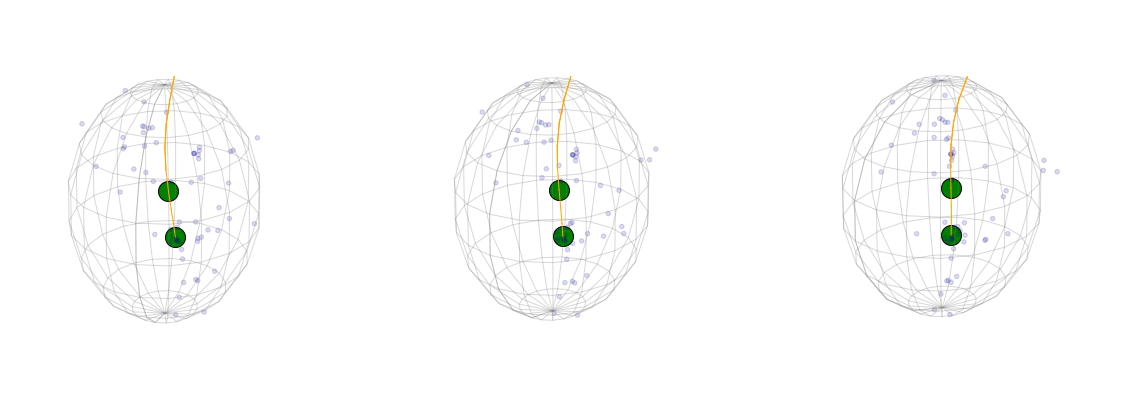

In [510]:
filament_length = segs_insphere.apply(lambda row: distance.euclidean(row[['U0','U1','U2']], row[['V0','V1','V2']]), axis=1)
print "Number of critical points: ", crits_insphere.shape[0]
print "Total length of filament: ", filament_length.sum()


fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
# fig.tight_layout()

for ax, angle in zip([ax1, ax2, ax3], [15,35,55]):
    
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]

    x = distances.max()/2 * np.cos(u)*np.sin(v) + centre[0]
    y = distances.max()/2 * np.sin(u)*np.sin(v) + centre[1]
    z = distances.max()/2 * np.cos(v) + centre[2]
    ax.plot_wireframe(x, y, z, color="grey", alpha=0.3)

    ax.scatter(coods['zn_x'], coods['zn_y'], coods['zn_z'],
              c = 'blue', alpha=0.15)

    ax.scatter(crits_insphere['X0'], crits_insphere['X1'], crits_insphere['X2'],
              s = 400, c = 'green', depthshade=False)

    for i, row in segs_insphere.iterrows():
        ax.plot(row[['U0','V0']], row[['U1','V1']], row[['U2','V2']], c='orange')

    ax.view_init(20, angle)
    
    ax.set_xlim(coods['zn_x'].min(), coods['zn_x'].max())
    ax.set_ylim(coods['zn_y'].min(), coods['zn_y'].max())
    ax.set_zlim(coods['zn_z'].min(), coods['zn_z'].max())
    
    ax.set_axis_off()
    
    # ax.set_aspect('equal')

Metrics to use:
- How many critical points in the bounding sphere?
- what length of filament in the bounding sphere?

## DisPerSE on each protocluster

run disperse on the tracer galaxies for each cluster. Summary stats for each one.

In [18]:
n_crits = {'2p07': [], '3p10': [], '3p95': [], '5p03': [], '6p42': []}
n_segs = {'2p07': [], '3p10': [], '3p95': [], '5p03': [], '6p42': []}
l_segs = {'2p07': [], '3p10': [], '3p95': [], '5p03': [], '6p42': []}

redshift = ['2p07','3p10','3p95','5p03','6p42']
selection = ['sfr']#,'mstar']

# header is a different size for each file...
len_header = [111] + [104] * 9

for (z,select),lhead in zip(product(redshift, selection), len_header):
    
    print "z:",z,", select:",select

    gals = pd.read_csv('data/henriques2015a_z%s_%s.csv' % (z,select),
                        skiprows=lhead, skipfooter=1, engine='python')

    n_pcs = len(pd.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId']))

    for i in range(n_pcs):
        i = np.int(i)    

        # test whether file contains anything
        if len(open('data/disperse/out/pccoods_%s_%s_%04d.ascii.NDnet_s5.up.NDskl.S005.BRK.TRIM.ASMB.a.crits'%(z,select,i)).readlines()) < 4:
            n_crits[z].append(0)
        else:
            crits = pd.read_csv('data/disperse/out/pccoods_%s_%s_%04d.ascii.NDnet_s5.up.NDskl.S005.BRK.TRIM.ASMB.a.crits'%(z,select,i), 
                        header=None, skiprows=3, delim_whitespace=True)
            crits.columns = ['X0','X1','X2','value','type','pair_id','boundary']

            n_crits[z].append(crits.shape[0])


        # test whether file contains anything
        if len(open('data/disperse/out/pccoods_%s_%s_%04d.ascii.NDnet_s5.up.NDskl.S005.BRK.TRIM.ASMB.a.segs'%(z,select,i)).readlines()) < 4:
            n_segs[z].append(0)
        else:
            segs = pd.read_csv('data/disperse/out/pccoods_%s_%s_%04d.ascii.NDnet_s5.up.NDskl.S005.BRK.TRIM.ASMB.a.segs'%(z,select,i), 
                        header=None, skiprows=3, delim_whitespace=True)
            segs.columns = ['U0','U1','U2','V0','V1','V2','value_U','value_V','type','boundary']

            n_segs[z].append(segs.shape[0])

        l_segs[z].append(np.sum(segs.apply(lambda row: distance.euclidean(row[['U0','U1','U2']], row[['V0','V1','V2']]), axis=1)))

z: 2p07 , select: sfr
z: 3p10 , select: sfr
z: 3p95 , select: sfr
z: 5p03 , select: sfr
z: 6p42 , select: sfr


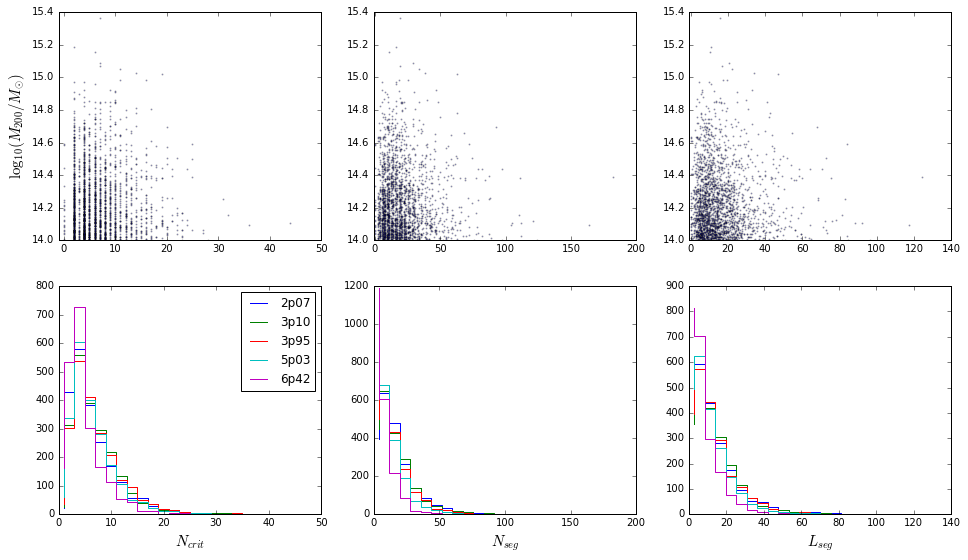

In [25]:
fig = plt.figure(figsize=(16,9))

binLimits_A = np.linspace(0, 50, 26)
bins_A = np.linspace(1, 49, 25)
binLimits_B = np.linspace(0, 200, 26)
bins_B = np.linspace(4, 196, 25)
binLimits_C = np.linspace(0, 140, 26)
bins_C = np.linspace(2.8, 137.2, 25)


# Scatter plots

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.scatter(n_crits['2p07'], cluster_masses, s=1, alpha=0.3)
ax2.scatter(n_segs['2p07'], cluster_masses, s=1, alpha=0.3)
ax3.scatter(l_segs['2p07'], cluster_masses, s=1, alpha=0.3)

ax1.set_xlim(-1, binLimits_A[::-1][0])
ax2.set_xlim(-1, binLimits_B[::-1][0])
ax3.set_xlim(-1, binLimits_C[::-1][0])


ax1.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$', size=15)

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(14,15.4)

# Histograms

ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

for i,z in enumerate(redshift):
    ax4.step(bins_A, np.histogram(n_crits[z], bins=binLimits_A)[0], label='%s'%z)
    ax5.step(bins_B, np.histogram(n_segs[z], bins=binLimits_B)[0], label='%s'%z)
    ax6.step(bins_C, np.histogram(l_segs[z], bins=binLimits_C)[0], label='%s'%z)


ax4.legend()    

ax4.set_xlabel('$N_{crit}$', size=15)
ax5.set_xlabel('$N_{seg}$', size=15)
ax6.set_xlabel('$L_{seg}$', size=15)
